In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import os
import copy

In [2]:
num_classes = 2 
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


CUDA is not available.  Training on CPU ...


In [3]:

data_dir = '/content/drive/MyDrive/Colab Notebooks/Malaria Detector Code/cell_images'
train_dir = data_dir + '/Train'
valid_dir = data_dir + '/Test'

In [4]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train', 'Test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=1)
                for x in ['Train', 'Test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Test']}
    
train_data = datasets.ImageFolder(train_dir, transform=data_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms)

batch_size = 64
num_workers=0

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/Colab Notebooks/Malaria Detector Code/cell_images\\Train'

In [15]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)


In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



In [17]:
model_ft = models.resnet50(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)







Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Loss: 0.5532 Acc: 0.7200
Test Loss: 0.1875 Acc: 0.9300

Epoch 1/14
----------
Train Loss: 0.2990 Acc: 0.8600
Test Loss: 0.1494 Acc: 0.9500

Epoch 2/14
----------
Train Loss: 0.2898 Acc: 0.8900
Test Loss: 0.0127 Acc: 1.0000

Epoch 3/14
----------
Train Loss: 0.2159 Acc: 0.9100
Test Loss: 0.0096 Acc: 1.0000

Epoch 4/14
----------
Train Loss: 0.2720 Acc: 0.9000
Test Loss: 0.0346 Acc: 1.0000

Epoch 5/14
----------
Train Loss: 0.2508 Acc: 0.9100
Test Loss: 0.0777 Acc: 0.9700

Epoch 6/14
----------
Train Loss: 0.8412 Acc: 0.7700
Test Loss: 0.0018 Acc: 1.0000

Epoch 7/14
----------
Train Loss: 0.0980 Acc: 0.9800
Test Loss: 0.0036 Acc: 1.0000

Epoch 8/14
----------
Train Loss: 0.1522 Acc: 0.9600
Test Loss: 0.0005 Acc: 1.0000

Epoch 9/14
----------
Train Loss: 0.3438 Acc: 0.8400
Test Loss: 0.0013 Acc: 1.0000

Epoch 10/14
----------
Train Loss: 0.1042 Acc: 0.9300
Test Loss: 0.0019 Acc: 1.0000

Epoch 11/14
----------
Train Loss: 0.1023 Acc: 0.9500
Test Loss: 0.0020 Acc: 1.0000

Epoch 12/14


In [31]:


torch.save(model_ft.state_dict(), 'smear_analyser.pt')

In [30]:
#Testing the save model on an image

#func to load model

def load_model(model_path):
  model= models.resnet50(pretrained=True)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)
 
  model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=False)
  model.eval()
  return model

In [33]:
model=load_model('smear_analyser.pt')

In [37]:

from PIL import Image

def predict_image(img_path):
  print('Image prediction in progress')
  image=Image.open(img_path)

  transformation=transforms.Compose(
      [
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
      ]
  )
  img_tensor=transformation(image).float()
  img_tensor=img_tensor.unsqueeze_(0)

  if torch.cuda.is_available():
    img_tensor.cuda()
  
  from torch.autograd import variable
  input=variable(img_tensor)
  output=model(input)

  idx=output.data.numpy().argmax()
  return idx

In [44]:
#Specific func to process image

def process_image(image):
    
    img_transforms = transforms.Compose([
            transforms.Resize(255),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
        ])
    
    image = img_transforms(Image.open(image))
    
    return image

In [45]:
#func to display image to be tested

import matplotlib.pyplot as plt
import numpy as np



def show_image(image, mx=None, title=None):
   
    if mx is None:
        fig, mx = plt.subplots()
    
  
    image = image.numpy().transpose((1, 2, 0))
    
   
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
   
    image = np.clip(image, 0, 1)
    
    mx.imshow(image)
    
    return mx


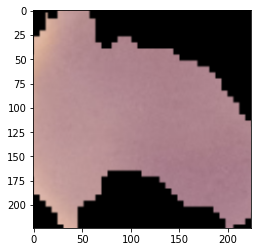

In [49]:
img=process_image('/content/drive/MyDrive/Colab Notebooks/Malaria Detector Code/cell_images/Test/Uninfected/C1_thinF_IMG_20150604_104722_cell_66.png')

show_image(img)

In [50]:
idx=predict_image('/content/drive/MyDrive/Colab Notebooks/Malaria Detector Code/cell_images/Test/Uninfected/C1_thinF_IMG_20150604_104722_cell_66.png')

if (idx==0):
  print("Tested Positive for malaria")
elif(idx==1):
  print("Tested Negative for malaria")

Image prediction in progress
Tested Negative for malaria


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:249: UserWarning: torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead
  warnings.warn("torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead")
/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:250: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(*args, **kwargs)
